Found 12745 files belonging to 12 classes.
Using 3824 files for training.
Found 12745 files belonging to 12 classes.
Using 3823 files for validation.


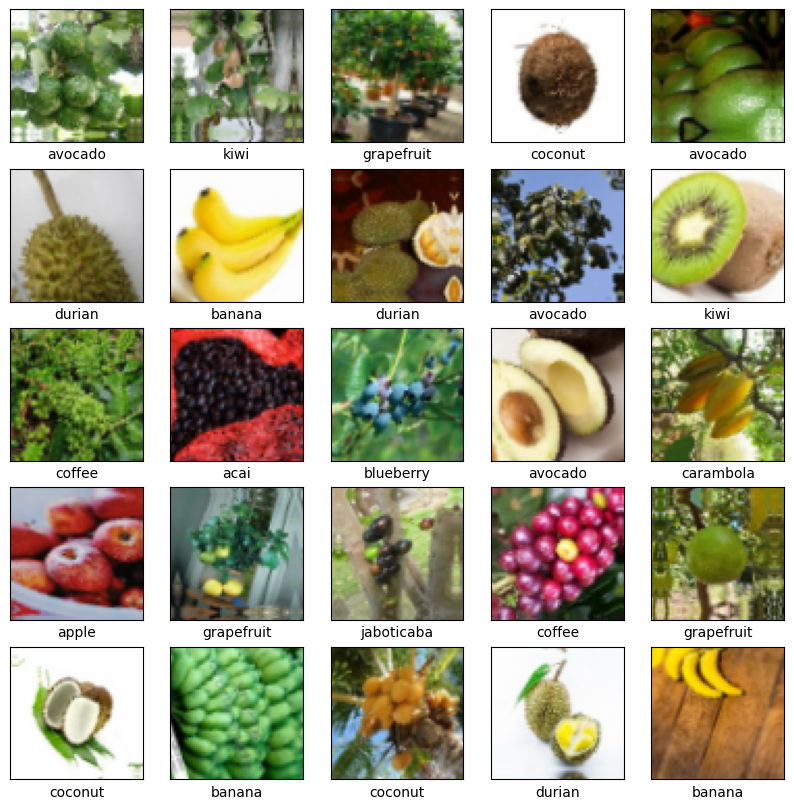

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, BatchNormalization, Activation
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load the Fruits262 dataset
data_dir = 'D:/OneDrive/Bernardo/Frutas/Fruit-262/'  # Replace with the actual path to the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.7,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=128,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=128,
)

# Define data augmentation options
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal")
])

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

class_names = train_ds.class_names

# Visualize a few images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.xlabel(class_names[labels[i]])
plt.show()



In [3]:
# Use the DenseNet121 model as the base model
base_model = DenseNet121(include_top=False, weights=None, input_shape=(64, 64, 3))
x = base_model.output

# Add a global average pooling layer
x = layers.GlobalAveragePooling2D()(x)

# Add a dense layer with ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Add the final output layer
outputs = layers.Dense(len(class_names))(x)

# Create the DenseNet model
model = Model(inputs=base_model.input, outputs=outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [13]:
# Compile and train the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=20,
)

Epoch 1/20
30/30 [==============================] - 106s 3s/step - loss: 0.7363 - accuracy: 0.7403 - val_loss: 2.0989 - val_accuracy: 0.4774
Epoch 2/20
30/30 [==============================] - 86s 3s/step - loss: 0.6771 - accuracy: 0.7683 - val_loss: 3.0365 - val_accuracy: 0.4264
Epoch 3/20
30/30 [==============================] - 86s 3s/step - loss: 0.6046 - accuracy: 0.7879 - val_loss: 2.0888 - val_accuracy: 0.4847
Epoch 4/20
30/30 [==============================] - 87s 3s/step - loss: 0.5948 - accuracy: 0.7853 - val_loss: 1.9910 - val_accuracy: 0.5103
Epoch 5/20
30/30 [==============================] - 86s 3s/step - loss: 0.5948 - accuracy: 0.7931 - val_loss: 2.6478 - val_accuracy: 0.3748
Epoch 6/20
30/30 [==============================] - 86s 3s/step - loss: 0.5991 - accuracy: 0.7916 - val_loss: 1.7909 - val_accuracy: 0.5449
Epoch 7/20
30/30 [==============================] - 86s 3s/step - loss: 0.5616 - accuracy: 0.8109 - val_loss: 2.2841 - val_accuracy: 0.4319
Epoch 8/20
30/30 [=

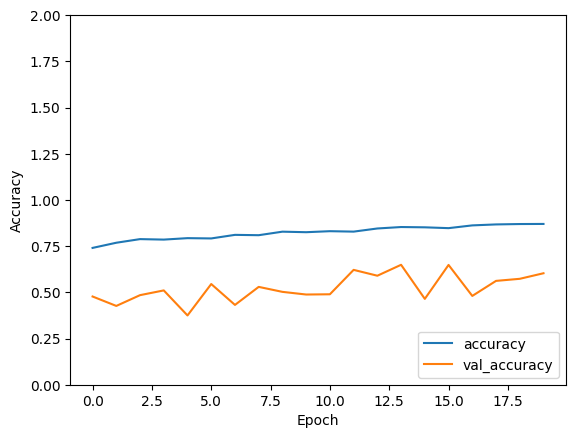

In [14]:
# Plot the accuracy and loss curves
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 2])
plt.legend(loc="lower right")
plt.show()

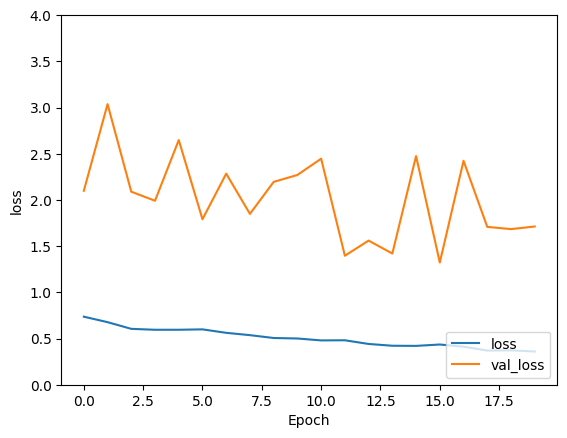

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

In [16]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print("Test accuracy:", test_acc)

30/30 - 13s - loss: 1.7123 - accuracy: 0.6032 - 13s/epoch - 445ms/step
Test accuracy: 0.6031911969184875


In [17]:
from pickle import dump
dump(model, open('modelo_densenet_20.pkl', 'wb'))